In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
file_path ='/content/drive/MyDrive/Multilayer Perceptron/Data/Experiemental_BTCs.csv' # Update to your local path
df = pd.read_csv(file_path)
df = np.array(df)
time = df[:,0]
time = time.reshape(-1,1)
experiments = df[:,1:].T

In [ ]:
max_c =[]
t_peak =[]

for i in range(0,df.shape[1],2):
  concentration = df[:,i+1]
  max_concentrion = np.nanargmax(concentration)
  time = df[:,i]
  time_peak = time[max_concentrion]
  t_peak = np.append(t_peak,time_peak)
  max_c = np.append(max_c,np.nanmax(concentration))

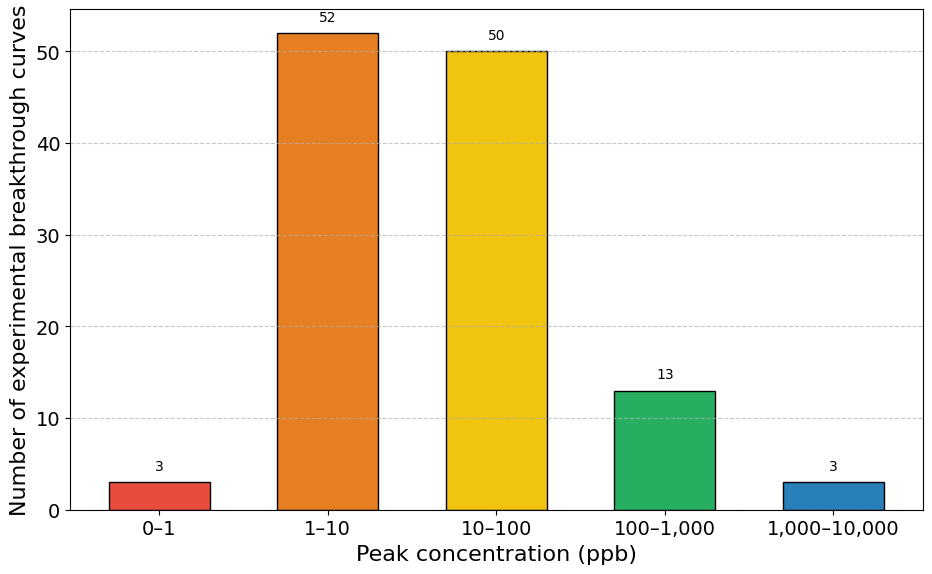

In [ ]:

log_min = np.floor(np.log10(max_c.min()))
log_max = np.ceil(np.log10(max_c.max()))
bins = np.logspace(log_min, log_max, int(log_max - log_min) + 1)

counts, bin_edges = np.histogram(max_c, bins=bins)

colors = ["#e74c3c", "#e67e22", "#f1c40f", "#27ae60", "#2980b9"]
plt.figure(figsize=(11, 6.5))
bars = plt.bar(range(len(counts)), counts, color=colors,width=0.6, edgecolor="black")

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
                 ha='center', va='bottom', fontsize=10)

plt.xticks(ticks=range(len(bin_edges)-1),
           labels=[f"{int(bin_edges[i]):,}–{int(bin_edges[i+1]):,}" for i in range(len(bin_edges)-1)],
           rotation=0)
plt.xlabel("Peak concentration (ppb)",fontsize=16)
plt.ylabel("Number of experimental breakthrough curves",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


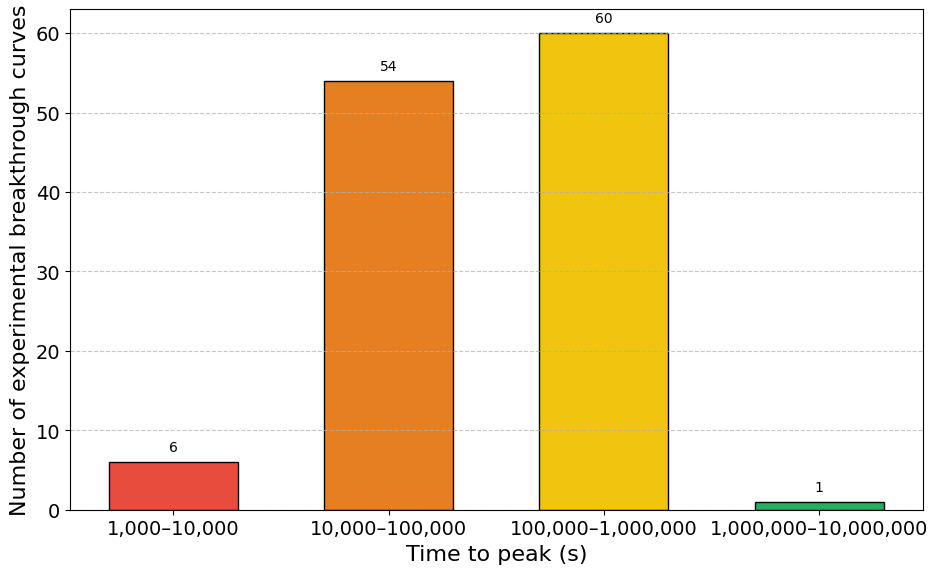

In [ ]:
t_peak_sec = t_peak*3600
log_min = np.floor(np.log10(t_peak_sec.min()))
log_max = np.ceil(np.log10(t_peak_sec.max()))
bins = np.logspace(log_min, log_max, int(log_max - log_min) + 1)

counts, bin_edges = np.histogram(t_peak_sec, bins=bins)

colors = ["#e74c3c", "#e67e22", "#f1c40f", "#27ae60", "#2980b9"]
plt.figure(figsize=(11, 6.5))
bars = plt.bar(range(len(counts)), counts, color=colors,width=0.6, edgecolor="black")

for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
                 ha='center', va='bottom', fontsize=10)

plt.xticks(ticks=range(len(bin_edges)-1),
           labels=[f"{int(bin_edges[i]):,}–{int(bin_edges[i+1]):,}" for i in range(len(bin_edges)-1)],
           rotation=0)
plt.xlabel("Time to peak (s)",fontsize=16)
plt.ylabel("Number of experimental breakthrough curves",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_time (t_initial, t_final, n_timesteps):
    t_numpy = np.linspace(t_initial, t_final, n_timesteps)
    t_reshape = t_numpy.reshape(1, -1)
    t_torch = torch.tensor(t_reshape, dtype=torch.float32).to(device)
    return t_numpy, t_reshape, t_torch


df = pd.read_csv(file_path)
df_numeric = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
data = df_numeric.to_numpy()
corrected_data = data.copy()
columns = df.columns

In [ ]:
for i in range(0, data.shape[1], 2):
    if i + 1 >= data.shape[1]:
        break  # Ensure we have a pair of columns
    time_col = data[:, i]
    conc_col = data[:, i + 1]

    # Ignore nan values
    valid_indices = ~np.isnan(conc_col)
    time_values = time_col[valid_indices]
    conc_values = conc_col[valid_indices]

    if len(conc_values) == 0:
        continue

    peak_idx = np.argmax(conc_values)

    # Ensure increasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one decreasing value).
    while True:
        fixed = False
        for j in range(1, peak_idx):
            if conc_values[j] < conc_values[j - 1]:  # Not increasing (worng behavior)
                next_valid_idx = j + 1
                while next_valid_idx <= peak_idx and conc_values[next_valid_idx] < conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx <= peak_idx:
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    # Ensure decreasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one increaing value).
    while True:
        fixed = False
        for j in range(peak_idx + 1, len(conc_values) - 1):
            if conc_values[j] > conc_values[j - 1]:  # Not decreasing (wrong behavior)
                next_valid_idx = j + 1
                while next_valid_idx < len(conc_values) and conc_values[next_valid_idx] > conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx < len(conc_values):
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    corrected_data[valid_indices, i + 1] = conc_values

In [ ]:
df = np.array(corrected_data)
# Calculate truncation time
ratios =[]

for i in range(0,df.shape[1],2):
  concentration = df[:,i+1]
  max_concentrion = np.nanargmax(concentration)
  time = df[:,i]
  time_peak = time[max_concentrion]
  time_max = np.nanmax(time)
  ratio = time_max/time_peak
  ratios = np.append(ratios,ratio)

ratios = ratios.reshape(-1,1)

In [ ]:
# Define quality ranges

very_low_quality = []
low_quality = []
medium_quality = []
high_quality = []
very_high_quality = []

# Separate by quality range
for i in range(len(ratios)):
  if ratios[i] < 2:
    very_low_quality.append(ratios[i])
  elif ratios[i] < 5:
    low_quality.append(ratios[i])
  elif ratios[i] < 10:
    medium_quality.append(ratios[i])
  elif ratios[i] < 20:
    high_quality.append(ratios[i])
  else:
    very_high_quality.append(ratios[i])

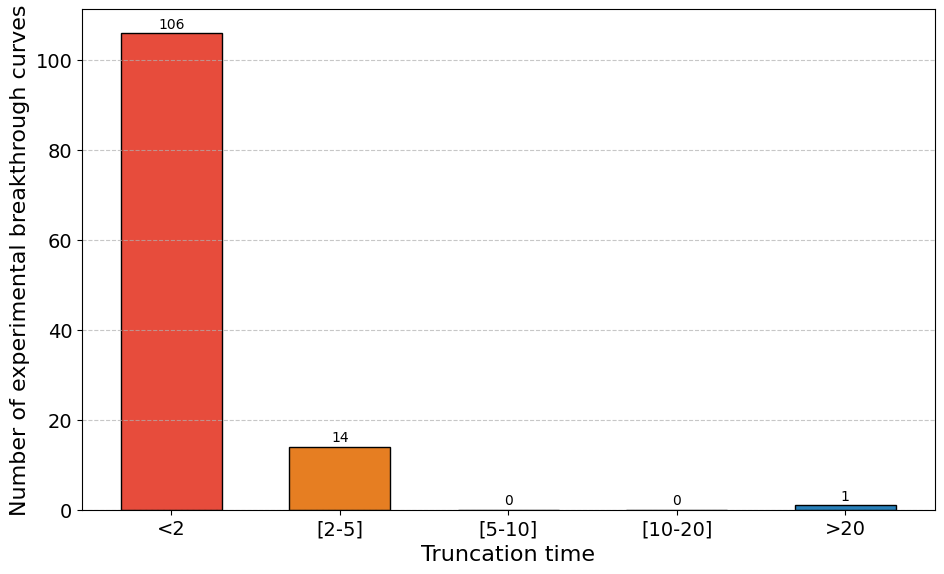

In [ ]:
categories = ["<2", "[2-5]", "[5-10]", "[10-20]", ">20"]
values = [
    len(very_low_quality),
    len(low_quality),
    len(medium_quality),
    len(high_quality),
    len(very_high_quality)
]

colors = ["#e74c3c", "#e67e22", "#f1c40f", "#27ae60", "#2980b9"]

plt.figure(figsize=(11,6.5))
bars = plt.bar(categories, values, color=colors, width=0.6, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f"{height}", ha='center', va='bottom', fontsize=10)

plt.xlabel("Truncation time", fontsize=16)
plt.ylabel("Number of experimental breakthrough curves", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

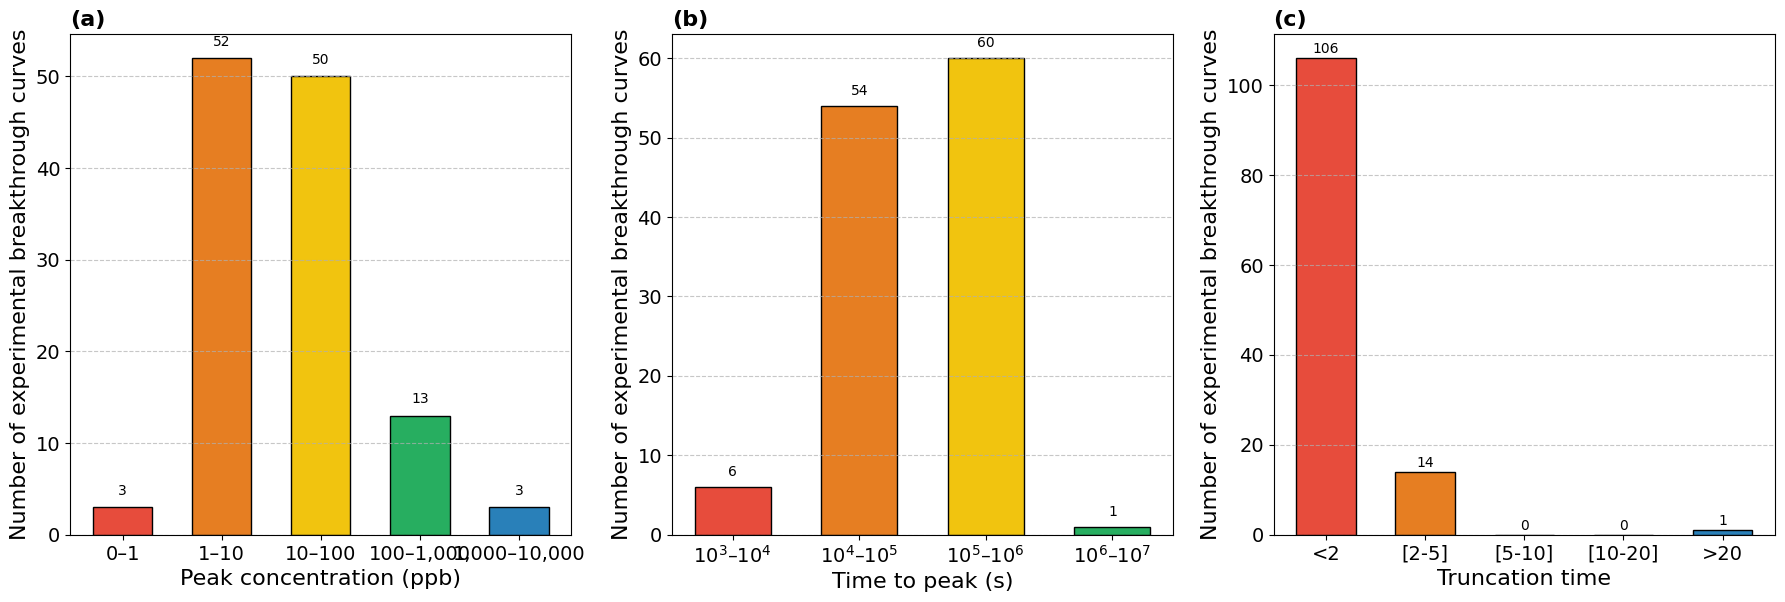

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6.5))
colors = ["#e74c3c", "#e67e22", "#f1c40f", "#27ae60", "#2980b9"]

# PANEL 1: Peak concentration (ppb)
log_min = np.floor(np.log10(max_c.min()))
log_max = np.ceil(np.log10(max_c.max()))
bins = np.logspace(log_min, log_max, int(log_max - log_min) + 1)
counts, bin_edges = np.histogram(max_c, bins=bins)
ax = axes[0]

bars = ax.bar(range(len(counts)), counts, color=colors, width=0.6, edgecolor="black")
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
                ha='center', va='bottom', fontsize=10)

ax.set_xticks(range(len(bin_edges)-1))
ax.set_xticklabels([f"{int(bin_edges[i]):,}–{int(bin_edges[i+1]):,}" for i in range(len(bin_edges)-1)], rotation=0)
ax.set_xlabel("Peak concentration (ppb)", fontsize=16)
ax.set_ylabel("Number of experimental breakthrough curves", fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_title("(a)", fontsize=16, fontweight='bold', loc='left')

# PANEL 2: Time to peak (s)
log_min = np.floor(np.log10(t_peak_sec.min()))
log_max = np.ceil(np.log10(t_peak_sec.max()))
bins = np.logspace(log_min, log_max, int(log_max - log_min) + 1)
counts, bin_edges = np.histogram(t_peak_sec, bins=bins)
ax = axes[1]

bars = ax.bar(range(len(counts)), counts, color=colors, width=0.6, edgecolor="black")
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
                ha='center', va='bottom', fontsize=10)

ax.set_xticks(range(len(bin_edges)-1))

ax.set_xticklabels([rf"$10^{{{int(np.log10(bin_edges[i]))}}}$–$10^{{{int(np.log10(bin_edges[i+1]))}}}$" for i in range(len(bin_edges) - 1)],rotation=0,fontsize=14)

ax.set_xlabel("Time to peak (s)", fontsize=16)
ax.set_ylabel("Number of experimental breakthrough curves", fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_title("(b)", fontsize=16, fontweight='bold', loc='left')

# PANEL 3: Truncation time categories
categories = ["<2", "[2-5]", "[5-10]", "[10-20]", ">20"]
values = [
    len(very_low_quality),
    len(low_quality),
    len(medium_quality),
    len(high_quality),
    len(very_high_quality)
]
ax = axes[2]
bars = ax.bar(categories, values, color=colors, width=0.6, edgecolor="black")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            f"{height}", ha='center', va='bottom', fontsize=10)

ax.set_xlabel("Truncation time", fontsize=16)
ax.set_ylabel("Number of experimental breakthrough curves", fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_title("(c)", fontsize=16, fontweight='bold', loc='left')
plt.show()
